# Multi-layer perceptron

This demo shows MLP

In [1]:
## If problems arise with the loading of the shared library, this script can be used to load the shared library before other libraries.
## Remember to also run on your local machine the script below:
# bash replace_lib_version.sh

import platform
import ctypes

if platform.system() == "Linux":
    # Force libgomp to be loaded before other libraries consuming dynamic TLS (to avoid running out of STATIC_TLS)
    ctypes.cdll.LoadLibrary("libgomp.so.1")
    ctypes.cdll.LoadLibrary(
        "/home/vscode/.local/lib/python3.12/site-packages/py_nillion_client/py_nillion_client.abi3.so"
    )

In [2]:
import json
import os
from typing import Dict

import os
import torch
from torch import nn
from torchvision import transforms
import py_nillion_client as nillion
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support,
)
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from dotenv import load_dotenv

# Using Nada AI model client
from nada_ai.client import TorchClient
import nada_algebra as na
import py_nillion_client as nillion
from nillion_python_helpers import (
    create_nillion_client,
    getUserKeyFromFile,
    getNodeKeyFromFile,
)

/home/vscode/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### Train an Covid classification model

Before this step you must install kaggle

In [3]:
!kaggle datasets download mehradaria/covid19-lung-ct-scans -p data --unzip

In [4]:
class CovidDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir: os.PathLike, transform) -> None:
        self.root_dir = root_dir
        self.transform = transform

        self.classes = ["Non-COVID-19", "COVID-19"]

        self.data = []
        self.targets = []

        for class_index, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_dir):
                if filename.endswith(".png"):
                    img_path = os.path.join(class_dir, filename)
                    self.data.append(img_path)
                    self.targets.append(class_index)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = self.data[index]
        label = self.targets[index]

        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        return img, label

In [5]:
# Create custom torch Module
class MyNN(torch.nn.Module):
    """My simple neural net"""

    def __init__(self) -> None:
        """Model is a two layers and an activations"""
        super(MyNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=2, kernel_size=3, stride=4, padding=1
        )
        self.pool = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1 = torch.nn.Linear(in_features=8, out_features=2)

        self.relu = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()

    def forward(self, x: np.ndarray) -> np.ndarray:
        """My forward pass logic"""
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x


my_model = MyNN()

In [6]:
dataset = CovidDataset(
    os.path.join("data", "COVID-19_Lung_CT_Scans"),
    transform=transforms.Compose(
        [
            transforms.Grayscale(),
            transforms.Resize((16, 16)),
            transforms.ToTensor(),
        ]
    ),
)
trainset, testset = torch.utils.data.random_split(dataset, [0.8, 0.2])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(my_model.parameters(), lr=1e-4)

In [7]:
accuracies, losses = [], []
for epoch in range(10):
    print(f"Starting epoch {epoch+1}...")

    incorrect, correct = 0, 0
    current_loss = 0
    for i, data in enumerate(trainloader):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = my_model(inputs)
        loss = loss_function(outputs, targets)

        preds = torch.argmax(outputs, axis=1)

        correct += (preds == targets).float().sum()
        incorrect += (preds != targets).float().sum()

        loss.backward()
        optimizer.step()

        current_loss += loss.item()
        if i % 100 == 99:
            accuracy = 100 * correct / (incorrect + correct)
            accuracies.append(accuracy)

            print("Loss after mini-batch %5d: %.3f" % (i + 1, current_loss / 100))
            losses.append(current_loss / 100)
            print("Accuracy after mini-batch %5d: %.3f" % (i + 1, accuracy))

            correct, incorrect = 0, 0
            current_loss = 0

Starting epoch 1...
Loss after mini-batch   100: 0.506
Accuracy after mini-batch   100: 87.312
Loss after mini-batch   200: 0.489
Accuracy after mini-batch   200: 87.812
Loss after mini-batch   300: 0.459
Accuracy after mini-batch   300: 89.875
Loss after mini-batch   400: 0.463
Accuracy after mini-batch   400: 87.688
Starting epoch 2...
Loss after mini-batch   100: 0.433
Accuracy after mini-batch   100: 88.875
Loss after mini-batch   200: 0.424
Accuracy after mini-batch   200: 88.500
Loss after mini-batch   300: 0.418
Accuracy after mini-batch   300: 87.875
Loss after mini-batch   400: 0.411
Accuracy after mini-batch   400: 87.500
Starting epoch 3...
Loss after mini-batch   100: 0.384
Accuracy after mini-batch   100: 88.938
Loss after mini-batch   200: 0.373
Accuracy after mini-batch   200: 88.938
Loss after mini-batch   300: 0.382
Accuracy after mini-batch   300: 87.875
Loss after mini-batch   400: 0.386
Accuracy after mini-batch   400: 87.250
Starting epoch 4...
Loss after mini-batc

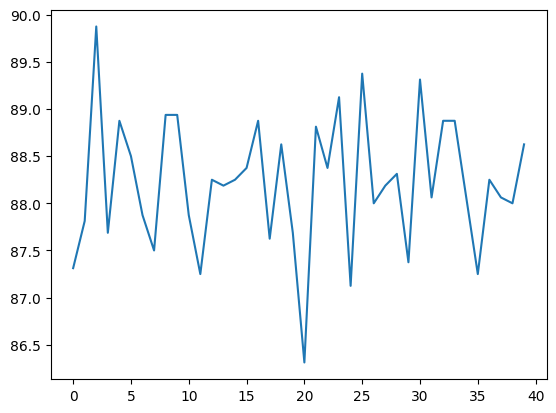

In [8]:
plt.plot(accuracies)

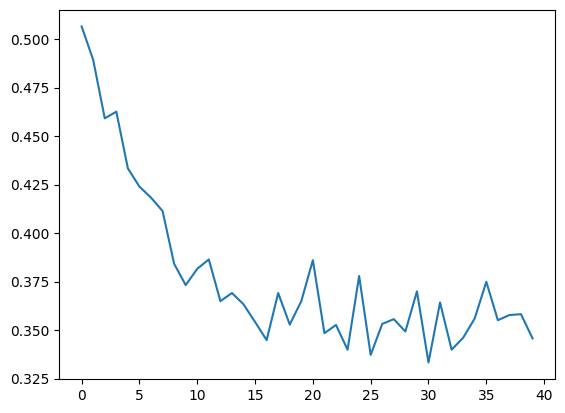

In [9]:
plt.plot(losses)

In [10]:
y_pred = []
y_true = []
for i, data in enumerate(testloader):
    inputs, targets = data

    outputs = my_model(inputs)
    preds = torch.argmax(outputs, axis=1)

    y_pred.extend(preds.tolist())
    y_true.extend(targets.tolist())

In [11]:
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
print("precision: {:.3f}%".format(precision[1] * 100))
print("recall: {:.3f}%".format(recall[1] * 100))
print("f1: {:.3f}%".format(f1[1] * 100))
print("support: {}".format(support[1]))

precision: 91.286%
recall: 100.000%
f1: 95.445%
support: 1540


/home/vscode/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


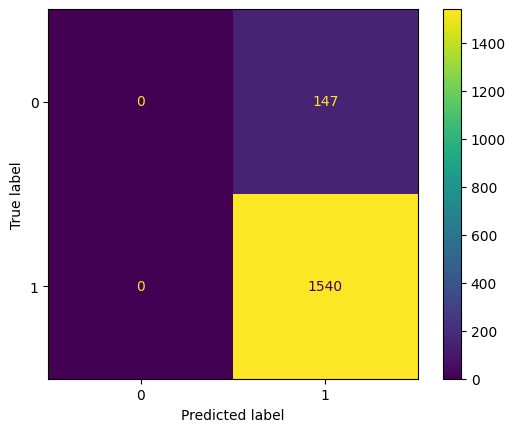

In [12]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
disp.plot()

## Model Provider flow

### Authenticate with Nillion

To connect to the Nillion network, we need to have a user key and a node key. These serve different purposes:

The `user_key` is the user's private key. The user key should never be shared publicly, as it unlocks access and permissions to secrets stored on the network.

The `node_key` is the node's private key which is run locally to connect to the network.

In [13]:
# Load all Nillion network environment variables
assert os.getcwd().endswith(
    "examples/multi_layer_perceptron"
), "Please run this script from the examples/multi_layer_perceptron directory otherwise, the rest of the tutorial may not work"
load_dotenv()

True

In [14]:
cluster_id = os.getenv("NILLION_CLUSTER_ID")
print(os.getenv("NILLION_USERKEY_PATH_PARTY_1"))
model_provider_userkey = getUserKeyFromFile(os.getenv("NILLION_USERKEY_PATH_PARTY_1"))
model_provider_nodekey = getNodeKeyFromFile(os.getenv("NILLION_NODEKEY_PATH_PARTY_1"))
model_provider_client = create_nillion_client(
    model_provider_userkey, model_provider_nodekey
)
model_provider_party_id = model_provider_client.party_id
model_provider_user_id = model_provider_client.user_id

/tmp/tmpsl1rnkrg


In [15]:
model_user_userkey = getUserKeyFromFile(os.getenv("NILLION_USERKEY_PATH_PARTY_2"))
model_user_nodekey = getNodeKeyFromFile(os.getenv("NILLION_NODEKEY_PATH_PARTY_2"))
model_user_client = create_nillion_client(model_user_userkey, model_user_nodekey)
model_user_party_id = model_user_client.party_id
model_user_user_id = create_nillion_client(
    model_user_userkey, model_user_nodekey
).user_id

### Upload Nada program to Nillion

TODO: explain what the Nada program does

In [16]:
async def store_program(
    *,
    client: nillion.NillionClient,
    cluster_id: str,
    user_id: str,
    nada_program_path: str,
) -> Dict[str, str]:
    """Stores Nada program binary in Nillion network.

    Args:
        client (nillion.NillionClient): Client that will upload Nada program.
        cluster_id (str): Nillion cluster ID.
        user_id (str): User ID of user that will upload Nada program.
        nada_program_path (str): Path to Nada program binary.

    Returns:
        Dict[str, str]: Resulting `action_id` and `program_id`.
    """
    action_id = await client.store_program(cluster_id, "main", nada_program_path)
    program_id = f"{user_id}/main"

    return {
        "action_id": action_id,
        "program_id": program_id,
    }

In [17]:
result_store_program = await store_program(
    client=model_provider_client,
    cluster_id=cluster_id,
    user_id=model_provider_user_id,
    nada_program_path="target/main.nada.bin",
)

action_id = result_store_program["action_id"]
program_id = result_store_program["program_id"]

print("✅ Program saved successfully!")
print("action_id:", action_id)
print("program_id:", program_id)

✅ Program saved successfully!
action_id: 880b4727-3763-4435-90ce-d5a66c5693f4
program_id: 5GnDBJ4brQtS7U3YsUdweoKUfbN7t9CNDaZ7AnVLarwWcRNfQUwr1Ct2aTQsMhhvjb1xeYPfiKAahMz7i5D85ZUd/main


### Upload weights to Nillion network

In [18]:
# Create and store model secrets via ModelClient
model_client = TorchClient(my_model)

In [19]:
async def store_model(
    *,
    model_client: TorchClient,
    client: nillion.NillionClient,
    cluster_id: str,
    program_id: str,
    party_id: str,
    model_user_user_id: str,
    model_provider_user_id: str,
) -> Dict[str, str]:
    """Stores model params in Nillion network.

    Args:
        model (MyModel): Model object to store in network.
        client (nillion.NillionClient): Nillion client that stores model params.
        cluster_id (str): Nillion cluster ID.
        program_id (str): Program ID of Nada program.
        party_id (str): Party ID of party that will store model params.
        model_user_user_id (str): User ID of user that will get compute permissions.
        model_provider_user_id (str): User ID of user that will provide model params.
        precision (int): Desired precision.

    Returns:
        Dict[str, str]: Resulting `provider_party_id` and `model_store_id`.
    """

    model_secrets = nillion.Secrets(
        model_client.export_state_as_secrets("my_nn", na.SecretRational)
    )

    secret_bindings = nillion.ProgramBindings(program_id)
    secret_bindings.add_input_party("Party0", party_id)

    permissions = nillion.Permissions.default_for_user(model_provider_user_id)
    compute_permissions = {
        model_user_user_id: {program_id},
    }
    # Give permission to model user to run inference
    permissions.add_compute_permissions(compute_permissions)

    store_id = await client.store_secrets(
        cluster_id, secret_bindings, model_secrets, permissions
    )

    return {
        "provider_party_id": party_id,
        "model_store_id": store_id,
    }

In [20]:
result_store_model = await store_model(
    model_client=model_client,
    client=model_provider_client,
    cluster_id=cluster_id,
    program_id=program_id,
    party_id=model_provider_party_id,
    model_user_user_id=model_user_user_id,
    model_provider_user_id=model_provider_user_id,
)

provider_party_id = result_store_model["provider_party_id"]
model_store_id = result_store_model["model_store_id"]

print("✅ Model params uploaded successfully!")
print("provider_party_id:", provider_party_id)
print("model_store_id:", model_store_id)

✅ Model params uploaded successfully!
provider_party_id: 12D3KooWQLbKxRFoa3rcA8do1R2o96yhgxGnJS5RbTr3ZJwQiQay
model_store_id: d6002305-15f9-4e76-b5aa-510560f89e75


In [21]:
# This information is needed by the model user
with open("data/tmp.json", "w") as provider_variables_file:
    provider_variables = {
        "program_id": program_id,
        "model_store_id": model_store_id,
        "model_provider_party_id": model_provider_party_id,
    }
    json.dump(provider_variables, provider_variables_file)

In [22]:
torch.save(my_model.state_dict(), "./data/my_model.pt")